In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os

import statsmodels

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier
import pickle
from sklearn import svm
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids

In [2]:
feature_names = np.loadtxt('/Users/borosabel/Documents/Uni/ML&Pattern Classification/UE/ML-PatterClassification/python/feature_names.txt', dtype=str).T
root_dir = "/Users/borosabel/Documents/Uni/ML&Pattern Classification/UE/ML-PatterClassification/python"
test_files_dir = "/Users/borosabel/Documents/Uni/ML&Pattern Classification/UE/ML-PatterClassification/python_test"
test_file_names = ['test00', 'test01', 'test02', 'test03', 'test04', 'test05', 'test06', 'test07', 'test08', 'test09', 'test10', 'test11', 'test12', 'test13', 'test14', 'test15']
labels = {'cowpig1':2, 'eueowl1':4, 'tawowl1':6, 'eucdov':3, 'grswoo':5, 'comcuc':1, 'other':0}
directories = ['cowpig1', 'eueowl1', 'tawowl1', 'eucdov', 'grswoo', 'comcuc']

sns.set_palette("Paired")

gbrd_features = ['raw_contrast_mean_3', 'cln_contrast_mean_3', 'raw_melspect_std_6', 'cln_mfcc_mean_0', 'cln_contrast_mean_4', 'raw_mfcc_std_0', 'cln_melspect_mean_5', 'cln_melspect_mean_4', 'zcr_mean', 'raw_mfcc_d_std_0', 'cln_melspect_mean_7', 'raw_mfcc_mean_12', 'raw_mfcc_mean_10', 'raw_contrast_std_3', 'raw_mfcc_mean_15', 'raw_mfcc_mean_16', 'raw_mfcc_mean_1', 'raw_melspect_std_3', 'raw_melspect_std_8', 'raw_melspect_std_5', 'raw_energy_std', 'raw_mfcc_mean_9']

In [3]:
REVENUES = np.asarray(
        [[ 0.05, -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 ],
         [-0.25,  1.  , -0.3 , -0.1 , -0.1 , -0.1 , -0.1 ],
         [-0.02, -0.1 ,  1.  , -0.1 , -0.1 , -0.1 , -0.1 ],
         [-0.25, -0.1 , -0.3 ,  1.  , -0.1 , -0.1 , -0.1 ],
         [-0.25, -0.1 , -0.3 , -0.1 ,  1.  , -0.1 , -0.1 ],
         [-0.25, -0.1 , -0.3 , -0.1 , -0.1 ,  1.  , -0.1 ],
         [-0.25, -0.1 , -0.3 , -0.1 , -0.1 , -0.1 ,  1.  ]])

In [4]:
def cost_function(y_true, y_pred, cost_matrix):
    total_cost = 0
    for i in range(len(y_true)):
        true_label = int(y_true[i])
        pred_label = int(y_pred[i])
        total_cost += cost_matrix[true_label][pred_label]
    return total_cost

<h2>Helper functions</h2>

In [5]:
def get_all_feature_files_path(directory_path):
    """
    Input: ONE full path to the directory ex: 'user/uni/ML/cowpig1'
    Returns a list of all the feature file paths in the given directory
    
    """
    file_names = os.listdir(directory_path)
    file_paths = [os.path.join(directory_path, file_name) for file_name in file_names if '.labels' not in file_name]
    file_paths = [file_path for file_path in file_paths if os.path.isfile(file_path)]
    return file_paths

In [6]:
def train_val_split_on_files(directory, test_ratio=0.2):
    """
    Input: ONE directory name ex: ['comcuc1']
    Returns back a list of files as a tuple (train_set, validation_set) split in according to test_ratio
    """
    for dir_ in directory:
        current_dir = root_dir + '/' + dir_
        file_paths = get_all_feature_files_path(current_dir)
        train_set, validation_set = train_test_split(file_paths, test_size=test_ratio)
    return train_set, validation_set

In [7]:
def clear_label_file(data, labels, decrease_null=False):
    '''
    Input: numpy array of the labels and data
    Returns: numpy array of the data and labels but clears the labels where the annotators aggreement wasn't
             100% in case the majority vote was 0.
    '''
    rows_to_delete = []
    for idx, row in enumerate(labels):
        if((row[0] == 0) and (np.sum(row) > 0)) :
            rows_to_delete.append(idx)
            
    if(decrease_null == True):
        counter = 25
        for idx, row in enumerate(labels):
            if((row[0] == 0) and (idx not in rows_to_delete) and (counter > 0)) :
                rows_to_delete.append(idx)
                counter -= 1
            
    labels_copy = np.delete(labels, rows_to_delete, axis=0)
    data_copy = np.delete(data, rows_to_delete, axis=0)
    return data_copy, labels_copy

In [8]:
def load_list_of_files(list_of_files: list):
    """
    Input: List of file names with full path, ideally the output of the train_val_split_on_files function.
    Returns two dataframe, the features and the labels according to the majority voteing.
    """
    all_files_in_dir = np.empty((0, 548))
    all_labels_in_dir = np.empty((0, 1))
    
    for file in list_of_files:
        corresponding_label_file = file.replace('.npy', '.labels.npy')
        
        data = np.load(file)
        labels = np.load(corresponding_label_file)
        data, labels = clear_label_file(data, labels, False)
        all_files_in_dir = np.concatenate((all_files_in_dir, data))
        all_labels_in_dir = np.concatenate((all_labels_in_dir, labels[:, :1]))
        
    X = pd.DataFrame(all_files_in_dir, columns = feature_names)
    y = pd.DataFrame(all_labels_in_dir, columns=["label"])
    
    return X, y

In [9]:
def get_all_files_from_all_dir():
    """
    Returns all the training data, training labels, validation data and validation labels as a dataframe.
    """
    cowpig_train_files, cowpig_val_files = train_val_split_on_files(['cowpig1'], 0.2)
    eueowl1_train_files, eueowl1_val_files = train_val_split_on_files(['eueowl1'], 0.2)
    tawowl1_train_files, tawowl1_val_files = train_val_split_on_files(['tawowl1'], 0.2)
    eucdov_train_files, eucdov_val_files = train_val_split_on_files(['eucdov'], 0.2)
    grswoo_train_files, grswoo_val_files = train_val_split_on_files(['grswoo'], 0.2)
    comcuc_train_files, comcuc_val_files = train_val_split_on_files(['comcuc'], 0.2)
    
    cowpig_X_train, cowpig_Y_train = load_list_of_files(cowpig_train_files)
    eueowl1_train, eueowl1_Y_train = load_list_of_files(eueowl1_train_files)
    tawowl1_X_train, tawowl1_Y_train = load_list_of_files(tawowl1_train_files)
    eucdov_X_train, eucdov_Y_train = load_list_of_files(eucdov_train_files)
    grswoo_X_train, grswoo_Y_train = load_list_of_files(grswoo_train_files)
    comcuc_X_train, comcuc_Y_train = load_list_of_files(comcuc_train_files)
    
    cowpig_X_val, cowpig_Y_val = load_list_of_files(cowpig_val_files)
    eueowl1_X_val, eueowl1_Y_val = load_list_of_files(eueowl1_val_files)
    tawowl1_X_val, tawowl1_Y_val = load_list_of_files(tawowl1_val_files)
    eucdov_X_val, eucdov_Y_val = load_list_of_files(eucdov_val_files)
    grswoo_X_val, grswoo_Y_val = load_list_of_files(grswoo_val_files)
    comcuc_X_val, comcuc_Y_val = load_list_of_files(comcuc_val_files)

    all_train_data = np.concatenate((cowpig_X_train, eueowl1_train, tawowl1_X_train, eucdov_X_train, grswoo_X_train, comcuc_X_train))
    all_val_data = np.concatenate((cowpig_X_val, eueowl1_X_val, tawowl1_X_val, eucdov_X_val, grswoo_X_val, comcuc_X_val))
    all_train_labels = np.concatenate((cowpig_Y_train, eueowl1_Y_train, tawowl1_Y_train, eucdov_Y_train, grswoo_Y_train, comcuc_Y_train))
    all_val_labels = np.concatenate((cowpig_Y_val, eueowl1_Y_val, tawowl1_Y_val, eucdov_Y_val, grswoo_Y_val, comcuc_Y_val))
    
    return all_train_data, all_val_data, all_train_labels, all_val_labels

In [10]:
def evaluate_and_create_submission_file(important_features, model):
    """
    Input: the features which you used for the training set and the trained model
    Returns a dataframe in the format of the accepted submission.
    """
    header = ['test00'] + [str(i/10000) for i in range(3000)]
    submission_df = pd.DataFrame(columns=header)
    submission_df['test00'] = test_file_names
    for i, test_file in enumerate(test_file_names):
        data = np.load(test_files_dir + '/' + test_file + '.npy')
        df = pd.DataFrame(data, columns=feature_names)
        df = df[important_features]
        predictions = model.predict(df)
        pred = [int(p) for p in predictions]
        submission_df.iloc[i, 1:] = pred
    return submission_df

In [11]:
def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

In [12]:
all_train_data, all_val_data, all_train_labels, all_val_labels = get_all_files_from_all_dir()
all_train_data = pd.DataFrame(all_train_data, columns=feature_names)
all_val_data = pd.DataFrame(all_val_data, columns=feature_names)
all_train_labels = pd.DataFrame(all_train_labels, columns=['label'])
all_val_labels = pd.DataFrame(all_val_labels, columns=['label'])

In [13]:
all_train_data = all_train_data[gbrd_features]
all_val_data = all_val_data[gbrd_features]

In [22]:
count = all_train_labels['label'].value_counts()
print(count)
n_samples = count.mean().astype(np.int64)
print(n_samples)

label
0.0    53313
2.0     7206
3.0     6614
1.0     4708
5.0     4006
6.0     3395
4.0     1784
Name: count, dtype: int64
11575


In [81]:
under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(all_train_data, all_train_labels['label'], n_samples,t='majority'))
X_under, y_under = under_sampler.fit_resample(all_train_data, all_train_labels['label'])

/Users/borosabel/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [86]:
# from imblearn.over_sampling import SMOTE
# over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under,n_samples, t='minority'),k_neighbors=2)
# X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

In [85]:
# all_train_data = pd.DataFrame(X_bal, columns=gbrd_features)
# all_train_labels = pd.DataFrame(y_bal, columns=['label'])

In [28]:
# We undersample the majority class here
under_sampler = RandomUnderSampler(random_state=42)
all_train_data, all_train_labels = under_sampler.fit_resample(all_train_data, all_train_labels['label'])

In [25]:
all_train_data = pd.DataFrame(all_train_data, columns=gbrd_features)
all_train_labels = pd.DataFrame(all_train_labels, columns=['label'])

In [37]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(all_train_labels['label']),y = all_train_labels['label'])
weights = dict(zip(np.unique(all_train_labels['label']), class_weights))
weights

{0.0: 0.2166504058124357,
 1.0: 2.4330497089117777,
 2.0: 1.6323812194535694,
 3.0: 1.7389309719406807,
 4.0: 6.2558532279112615,
 5.0: 2.9982340605570066,
 6.0: 3.4221466364323505}

<h2>Comparing training and validation dataset distribution</h2>

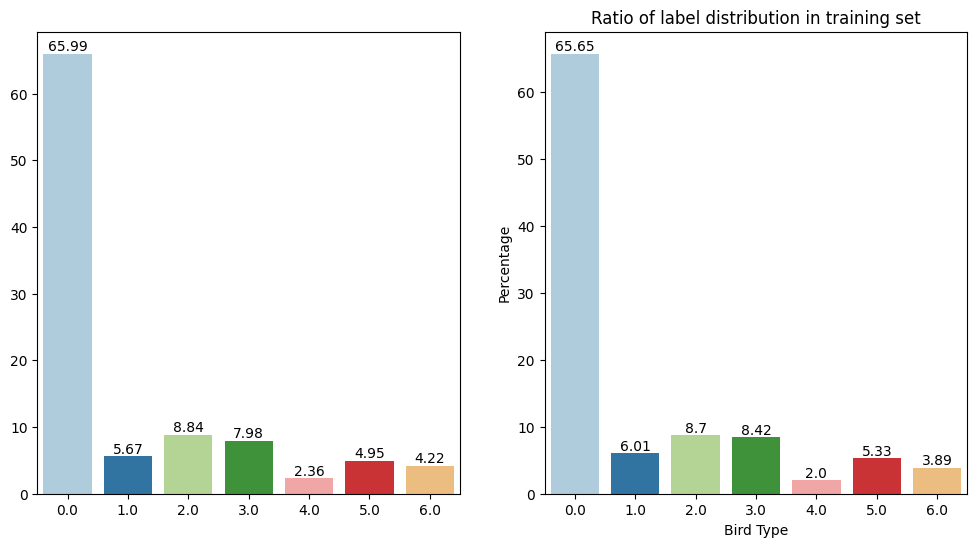

In [14]:
#----------DEALING WITH TRAINING DATA----------
unique_nums, counts = np.unique(all_train_labels, return_counts=True)
counts = np.round(counts / all_train_labels.shape[0] * 100, 2)

# Plot the bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x=unique_nums, y=counts, ax=ax[0])

# Set the labels and title
plt.xlabel('Bird Type')
plt.ylabel('Percentage')
plt.title('Ratio of label distribution in training set')

for i, count in enumerate(counts):
    ax[0].text(i, count, str(count), ha='center', va='bottom')
#----------DEALING WITH TRAINING DATA----------

#----------DEALING WITH VALIDATION DATA----------
unique_nums, counts = np.unique(all_val_labels, return_counts=True)
counts = np.round(counts / all_val_labels.shape[0] * 100, 2)

# Plot the bar chart
sns.barplot(x=unique_nums, y=counts, ax=ax[1])

# Set the labels and title
plt.xlabel('Bird Type')
plt.ylabel('Percentage')
plt.title('Ratio of label distribution in training set')

for i, count in enumerate(counts):
    ax[1].text(i, count, str(count), ha='center', va='bottom')

In [13]:
important_features = ['cln_melspect_mean_7', 'raw_contrast_mean_3', 'cln_contrast_mean_3', 'cln_melspect_mean_8', 'cln_melspect_mean_9', 'cln_melspect_mean_5',
       'raw_melspect_std_6', 'cln_melspect_mean_6', 'raw_melspect_std_7',
       'cln_contrast_mean_4', 'cln_melspect_mean_4', 'raw_energy_std',
       'cln_melspect_mean_10', 'cln_centroid_mean', 'cln_mfcc_mean_0',
       'cln_flatness_mean', 'raw_power_std', 'raw_melspect_std_8',
       'raw_mfcc_std_0', 'cln_mfcc_mean_9', 'raw_contrast_std_3',
       'raw_mfcc_d_std_0', 'raw_contrast_mean_4', 'raw_mfcc_mean_8',
       'cln_mfcc_mean_7', 'raw_mfcc_mean_12', 'raw_mfcc_mean_10',
       'raw_melspect_std_5', 'raw_flux_std', 'raw_mfcc_mean_7', 'zcr_mean',
       'raw_mfcc_mean_9', 'raw_mfcc_mean_16', 'yin_9', 'raw_mfcc_mean_13',
       'raw_power_mean', 'raw_melspect_std_9', 'raw_mfcc_std_1',
       'cln_contrast_mean_2', 'raw_mfcc_d_std_1', 'yin_6',
       'raw_melspect_std_4', 'raw_mfcc_mean_1', 'cln_contrast_std_3',
       'cln_mfcc_mean_1', 'yin_5', 'raw_mfcc_mean_15', 'raw_mfcc_mean_3',
       'cln_flux_mean', 'raw_mfcc_mean_14']

important_features2 = ['raw_contrast_mean_3', 'cln_contrast_mean_3', 'cln_melspect_mean_7', 'cln_melspect_mean_6', 'cln_melspect_mean_8', 'cln_melspect_mean_9', 'cln_melspect_mean_5', 'raw_melspect_std_7', 'raw_melspect_std_6', 'raw_energy_std', 'cln_melspect_mean_4', 'cln_mfcc_mean_0', 'raw_melspect_std_8', 'cln_contrast_mean_4', 'cln_centroid_mean', 'raw_mfcc_std_0', 'raw_mfcc_mean_9', 'raw_flux_std', 'cln_melspect_mean_10', 'raw_power_std', 'raw_mfcc_d_std_0', 'raw_contrast_mean_4', 'raw_mfcc_mean_8', 'raw_contrast_std_3', 'raw_melspect_std_5', 'raw_mfcc_mean_16', 'cln_flatness_mean', 'raw_mfcc_mean_10', 'cln_mfcc_mean_8', 'raw_mfcc_mean_12', 'cln_contrast_mean_2', 'zcr_mean', 'raw_mfcc_mean_7', 'cln_mfcc_mean_9', 'raw_mfcc_mean_13', 'raw_melspect_std_9', 'raw_mfcc_std_1', 'raw_power_mean', 'cln_flux_mean', 'raw_mfcc_d_std_1', 'yin_8', 'raw_mfcc_mean_15', 'raw_mfcc_mean_3', 'raw_mfcc_mean_17', 'yin_6', 'raw_melspect_std_4', 'cln_mfcc_mean_7', 'raw_mfcc_mean_1', 'yin_7', 'raw_contrast_mean_2']

In [14]:
most_correlated_features = ['cln_melspect_mean_10','cln_mfcc_mean_9','raw_melspect_std_34','raw_mfcc_mean_10',
                            'cln_contrast_mean_2','cln_melspect_mean_9','raw_contrast_mean_5','raw_melspect_std_30',
                            'raw_mfcc_std_1','cln_mfcc_mean_10','cln_flatness_mean','cln_mfcc_mean_7','cln_melspect_mean_8',
                            'cln_contrast_mean_5','raw_melspect_std_32','cln_mfcc_mean_4','cln_melspect_mean_6','raw_contrast_mean_3',
                            'cln_mfcc_mean_2','raw_mfcc_std_19','cln_melspect_mean_5','raw_mfcc_d_std_0','raw_melspect_std_33',
                            'raw_mfcc_d_std_1','cln_melspect_mean_4','cln_centroid_mean','cln_contrast_mean_3','raw_contrast_mean_4',
                            'cln_contrast_mean_4','raw_melspect_std_31','raw_mfcc_mean_8','raw_melspect_std_9','cln_melspect_mean_7',
                            'raw_melspect_std_8','raw_contrast_std_3','raw_mfcc_mean_9','cln_melspect_mean_3','cln_contrast_std_3',
                            'cln_mfcc_mean_8','raw_mfcc_std_0']

In [15]:
set1 = set(important_features)
set2 = set(important_features2)

common_values = list(set1 & set2)
print(len(common_values))

45


In [67]:
all_train_data = all_train_data[gbrd_features]
all_val_data = all_val_data[gbrd_features]
# all_train_data = all_train_data[important_features]
# all_val_data = all_val_data[important_features]

In [15]:
all_train_data.shape

(81392, 22)

In [47]:
# Train RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf.fit(all_train_data, all_train_labels['label'])
y_pred = rf.predict(all_val_data)

In [17]:
# Train GradientBoostingClassifier

gbrf_model = GradientBoostingClassifier(n_estimators=300)
gbrf_model.fit(all_train_data, all_train_labels['label'])

# Use the trained model for predictions
y_pred = gbrf_model.predict(all_val_data)

In [44]:
y_pred = ensemble_model.predict(all_val_data)

In [18]:
# # Save the trained model to a file
# filename = 'gbrf_model_full_features.sav'
# pickle.dump(gbrf_model, open(filename, 'wb'))

In [30]:
# feature_importances = clf.feature_importances_

# # Create a dataframe to hold the feature importances
# importance_df = pd.DataFrame({'Feature': all_train_data.columns, 'Importance': feature_importances})

# # Order the dataframe by importance in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)
# importance_df[importance_df['Importance'] >= 0.01].shape
# # Select the top n features
# # n = 22  # Set the desired number of top features
# # top_n_features = importance_df.head(n)

# # Display the top n features
# # print(list(top_n_features['Feature']))

(35, 2)

In [18]:
total_cost = cost_function(all_val_labels['label'], y_pred, REVENUES)

In [77]:
# n_estimators=300
# max_depth=None
total_cost

5459.880000001017

In [19]:
# n_estimators=100
# max_depth=5
total_cost

5146.320000000965

In [91]:
# n_estimators=100
# max_depth=10
# boosted
total_cost

5037.81000000138

In [54]:
# n_estimators=100
# max_depth=10
# min_samples_split=10
total_cost

5063.770000001338

In [60]:
# n_estimators=100
# max_depth=10
# min_samples_split=15
total_cost

5063.770000001338

In [ ]:
# n_estimators=200
total_cost

In [ ]:
# n_estimators=200
# max_depth=10
# min_samples_split=15
total_cost

In [ ]:
# n_estimators=300
# max_depth=10
# min_samples_split=15
total_cost

In [ ]:
# n_estimators=300
# max_depth=10
total_cost

In [20]:
sub_df = evaluate_and_create_submission_file(gbrd_features, gbrf_model)

In [21]:
sub_df.to_csv('submission_test5.csv', index=False, header=False)